# **CNN implementation**

- Consists of convolutional layers, where filters/kernels are applied to the mRNA sequence (in a matrix form) to detect certain patterns. These filters run through the mRNA sequences and give feature maps. These feature maps are then passed through a pooling layer, basically reducing the size of these feature maps while maintaining the most important features. This happens several times before all feature maps are flattened into a 1d array, allowing it to be fed into a normal artificial neural network, and the output layer is a single neuron with a value between 0 & 1. If the value is above a certain threshold, it is considered class 1, class 0 otherwise.

- CNNs are usually used on images, where the input can be thought of each individual pixel corresponding to a value, forming a matrix. In order to do the same with the mRNA sequence, we use perform one-hot encoding of the nucleotides. This means each A, U, G & C correspond to a one-hot vector of size (1, 4). For instance, A is [1, 0, 0, 0], U is [0, 1, 0, 0], G is [0, 0, 1, 0] and C is [0, 0, 0, 1]. This converts the mRNA sequence into a matrix form.

- We have 2 parts of the dataset, the training set and the test set. Within the training set, we allocate 20% of it to be a validation set. The validation set helps us detect whether our model is actually generalizing well, or just memorising the training set. For instance, if we see that the loss from the training set is decreasing but the loss from the validation set is increasing, it means our model is overfitting. The validation set allows for our model to make the necessary changes during training to prevent overfitting.

- Attributions: ChatGPT was used in generating the code of the functions that load the csv and fasta files, make the one-hot encoding function, as well as the functions that build and run the model.





# **Feature Extraction & Visualisation**
- no need for any explicit feature extraction in CNN as each convolutional layer in the CNN is basically a set of filters/kernels that detect the features of the mRNA. These optimal value of these filters/kernels are automatically learned during backpropagation.

- Because not all mRNA are of the same length, there will be 'missing values', since the input layer of the CNN only takes in a fixed length of mRNA. To solve this, we use padding. We set the maximum length of the mRNA allowed to be a certain value. If the length of the mRNA is longer than this value, then we just take a subset of the mRNA. If the mRNA is shorter than this value, we make up the remaining length with [0, 0, 0, 0] vectors.

- There are also 'rare values', which in this case are letters that are not A, U, G or C. For instance, the letter R could mean A or G. In this case, we average out the vector sum. A is [1, 0, 0, 0], G is [0, 0, 1, 0], so R is [1, 0, 1, 0] / 2 = [0.5, 0, 0.5, 0]. We do this for all the 'rare values'.

# **Related Works**
- https://www.nature.com/articles/s41598-021-93656-0 (Binary Classification of miRNA using CNN)

- in this article, some limitations discussed stem from the training dataset, where there were a limited number of samples (1124 samples), as well as an inbalance between the classes (417 +ve classes & 707 -ve classes), possibly resulting in the CNN not being able to generalize the features well enough.

- Our training class dataset has over 22000 sequences, so we need not worry about the limited training set. However, there is an imbalance in the number of classes in the dataset as well, with around 9000 class 1s and 14000 class 0s. In order to work around this, we decided to do threshold tuning. For context, the output of the CNN is a single neuron with the sigmoid activation function. If the value of the output is above a certain threshold, we classify it as class 1, else class 0. By default the threshold is 0.5. Using threshold tuning, we find the optimal threshold value, such that our true positive and true negative rates are higher. This allows for the CNN to better detect minority classes.

# **Experiments & Results**

- The performance metrics we decided to use for CNN include:

- Accuracy, which measures the fraction of samples correctly predicted. Formula: (TP + TN) / (TN + TP + FP + FN)
- Sensitivity, which refers to the true positive rate. Formula: TP / (TP + FN)
- Specificity, which refers to the true negative rate. Formula: TN / (TN + FP)
- Matthew's Correlation Coefficient(MCC), which measures the quality of binary classification models (our CNN in this case). The MCC ranges from 1 to -1, with 1 being perfect predictions, 0 being no better than random guessing, and -1 being total disagreement between the predicted and actual classes.
- Receiver Operating Characteristic(ROC) curve, used to evaluate the quality of a binary classification model. More specifically, the area under the curve (AUC) represents the models ability to distinguish between positive and negative classes. A higher AUC represents better model performance.

- The initial baseline model comprised of 2 convolutional(filter) layers. Additionally, our one-hot encoding function had a max_len value of 1000, which represents the number of nucleotides of a sequence it would take as input. RNA of length > 1000 would be truncated, where only the first 1000 nucletides are taken, while those of length < 1000 would be padded(mentioned under feature extraction & visualisation). In order to try and improve the performance of our model, we tried varying the max_len value, as well as the number of convolutional layers. Also, our threshold value for classification was kept as the default at 0.5.

![Screenshot](https://drive.google.com/uc?export=view&id=1ZK9h4a0sSNk2a6XP3SmGj73rdUaK_7x1)




- In order to improve our CNN mode, we decided to tweak and add a few things. Firstly, we decided to increase max_len to 1500 instead of 1000, so that the model could potentially generalize better given the longer sequences. Secondly, we optimized the model by introducing threshold tuning. Threshold tuning refers to varying the threshold value used when distinguishing between the 2 classes. For context, our output is a single neuron with a sigmoid activation function, so the output ranges between 0 and 1. Depending on whether this output value is above or below a certain threshold, it will be classified as either class 0 or 1. By default, this threshold value is 0.5. Instead of doing this, the model would first be tested on the validation set to find the optimal threshold value that balanced sensitvity and specificity before using that value on the test set.

![Screenshot](https://drive.google.com/uc?export=view&id=1LiP_SDIGxQuqJXstRDCFtSIKH81q82PK)


- Additional optimizations we decided to implement include early_stopping & varying of the learning rate. If no improvements are seen after 5 epochs, the model will just take the best weights recorded and use that, helping to save time when training. Additionally, we also reduce our learning rate when no improvements are seen after 3 epochs, to ensure that we do not overshoot the minima.

The code block below loads all the helper functions needed for the model, such as functions to load the fasta and csv file, as well as functions that format the training set and test set for the model to use.

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.models import (Sequential, load_model)
from keras.layers import (Conv1D, MaxPooling1D, BatchNormalization,
Dropout, GlobalAveragePooling1D, Dense, Flatten)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, matthews_corrcoef,
    accuracy_score, recall_score
)
import matplotlib.pyplot as plt
from google.colab import files

#Convert RNA into one hot encoded-vectors (Helper function)
base_to_onehot = {
    'A': np.array([1, 0, 0, 0]),
    'U': np.array([0, 1, 0, 0]),
    'G': np.array([0, 0, 1, 0]),
    'C': np.array([0, 0, 0, 1])
}

# Precomputed one-hot encoding for all IUPAC codes
IUPAC_RNA_ONEHOT = {
    'A': base_to_onehot['A'],
    'U': base_to_onehot['U'],
    'G': base_to_onehot['G'],
    'C': base_to_onehot['C'],
    'T': base_to_onehot['U'],  # T -> U
    'R': (base_to_onehot['A'] + base_to_onehot['G']) / 2,
    'Y': (base_to_onehot['C'] + base_to_onehot['U']) / 2,
    'S': (base_to_onehot['G'] + base_to_onehot['C']) / 2,
    'W': (base_to_onehot['A'] + base_to_onehot['U']) / 2,
    'K': (base_to_onehot['G'] + base_to_onehot['U']) / 2,
    'M': (base_to_onehot['A'] + base_to_onehot['C']) / 2,
    'B': (base_to_onehot['C'] + base_to_onehot['G'] + base_to_onehot['U']) / 3,
    'D': (base_to_onehot['A'] + base_to_onehot['G'] + base_to_onehot['U']) / 3,
    'H': (base_to_onehot['A'] + base_to_onehot['C'] + base_to_onehot['U']) / 3,
    'V': (base_to_onehot['A'] + base_to_onehot['C'] + base_to_onehot['G']) / 3,
    'N': (base_to_onehot['A'] + base_to_onehot['U'] + base_to_onehot['G'] + base_to_onehot['C']) / 4
}

def one_hot_encode_sequences(sequences, maxlen=1500):
    num_sequences = len(sequences)
    # Initialize output array with zeros (padding)
    X = np.zeros((num_sequences, maxlen, 4), dtype=float)

    for i, seq in enumerate(sequences):
        for j, base in enumerate(seq[:maxlen]):  # Only first maxlen nucleotides
            onehot = IUPAC_RNA_ONEHOT.get(base.upper(), IUPAC_RNA_ONEHOT['N'])
            X[i, j] = onehot

    return X

# Load FASTA (Helper function)
def load_fasta(filepath):
    sequences = {}
    res = []
    count = 0
    with open(filepath, 'r') as f:
        seq_id = None
        seq_chunks = []
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith('>'):
                if seq_id:
                    sequences[seq_id] = ''.join(seq_chunks)
                seq_id = line[1:].split()[0]
                seq_chunks = []
            else:
                seq_chunks.append(line.upper())
        if seq_id and seq_chunks:
             sequences[seq_id] = ''.join(seq_chunks)
    for name in sequences:
        res.append(sequences[name])

    return res ## returns fasta file converted to an array of sequences

# Load CSV labels (Helper function)
def load_labels(csv_path):
    labels = []
    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]

    for _, row in df.iterrows():

        labels.append(row['class'])
    return labels

#load mRNA in string form (Helper function)
def load_sequences(csv_path):
    seq = []

    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]

    for _, row in df.iterrows():
        seq.append(row['sequence'])
    return seq    ##array of the mRNA in string form

#Helper function
def get_dataset(seq_array, labels):
    X = one_hot_encode_sequences(seq_array)
    y = np.array(labels, dtype=np.int32)
    return X, y       ## y[n] corresponds to the class for X[n]

#CNN model used
def build_mrna_cnn(input_shape):
    model = Sequential([
    # 1st Convolutional Block
        Conv1D(64, 7, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        # 2nd Convolutional Block
        Conv1D(128, 5, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        # Global pooling and dense layers
        GlobalAveragePooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# **Initializing the dataset for testing**
- Before running the code block below, do the following:
- Create a new folder titled RNA_dataset.
- upload training.fa, training_class.csv & test.csv into this folder.

In [4]:
# Load training sequences from the FASTA file using the corrected function
seq_train = load_fasta("/content/RNA_dataset/training.fa")
# Load training labels from the CSV file
label_train = load_labels("/content/RNA_dataset/training_class.csv")


# Get dataset in the required format for the model
X, y = get_dataset(seq_train, label_train)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,      # 20% for validation
    random_state=42,
    stratify=y           # keeps class balance
)

# Load test data from the CSV file
test_csv_path = "/content/RNA_dataset/test.csv"
seq_test = load_sequences(test_csv_path)
label_test = load_labels(test_csv_path)

#test dataset
X_test, y_test = get_dataset(seq_test, label_test)





In the code block below, we will run the model on the training set, before testing it on the test set and displaying the performance metrics.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 176s 303ms/step - accuracy: 0.8744 - loss: 0.3300 - val_accuracy: 0.8887 - val_loss: 0.2830 - learning_rate: 1.0000e-04
Epoch 2/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 178s 312ms/step - accuracy: 0.8986 - loss: 0.2505 - val_accuracy: 0.9051 - val_loss: 0.2399 - learning_rate: 1.0000e-04
Epoch 3/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 200s 308ms/step - accuracy: 0.9051 - loss: 0.2392 - val_accuracy: 0.9185 - val_loss: 0.2186 - learning_rate: 1.0000e-04
Epoch 4/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 202s 307ms/step - accuracy: 0.9126 - loss: 0.2147 - val_accuracy: 0.9289 - val_loss: 0.1982 - learning_rate: 1.0000e-04
Epoch 5/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 203s 309ms/step - accuracy: 0.9158 - loss: 0.2031 - val_accuracy: 0.9136 - val_loss: 0.2207 - learning_rate: 1.0000e-04
Epoch 6/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 179s 313ms/step - accuracy: 0.9259 - loss: 0.1828 - val_accuracy: 0.9408 - val_loss: 0.1726 - learning_rate: 1.0000e-04
Epoch 7/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model and threshold saved!
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step
Accuracy:    0.8865
Sensitivity: 0.8877
Specificity: 0.8854
MCC:         0.7731


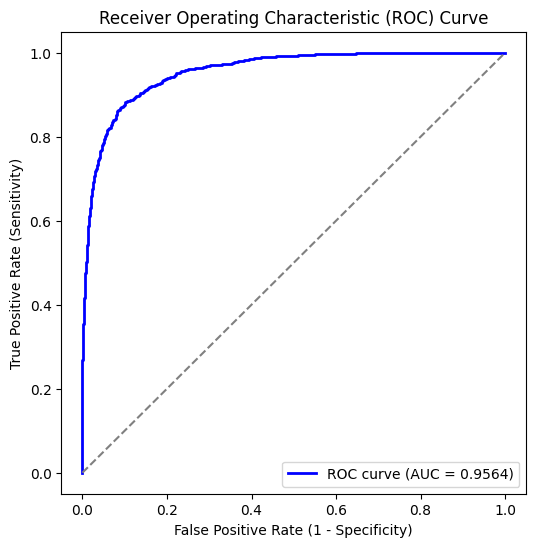

In [5]:
input_shape = (X.shape[1], X.shape[2])
model = build_mrna_cnn(input_shape)

# --- Callbacks:learning rate schedule --

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,             # reduce LR by half
    patience=3,             # after 3 epochs without improvement
    min_lr=1e-6,            # minimum learning rate
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',      # what to watch — usually validation loss
    patience=5,              # how many epochs to wait before stopping
    restore_best_weights=True,  # revert to model with lowest val_loss
    min_delta=1e-4,          # minimum change to qualify as improvement
    verbose=1                # print when training stops early
)

#Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[lr_schedule, early_stop]
)


#epochs = 20 meaning run through entire dataset 20 times
#batch_size = 32 meaning update weights and biases after every 32 samples

y_val_probs = model.predict(X_val).ravel()
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
best_thresh = thresholds[np.argmax(tpr - fpr)] #finding the optimal threshold value based
#on the validation set


y_pred_probs = model.predict(X_test).ravel() #predicted probs from model
y_pred = (y_pred_probs >= best_thresh).astype(int) #1s and 0s

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

accuracy = accuracy_score(y_test, y_pred)
sensitivity = tp / (tp + fn)  # TP / (TP + FN)
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_test, y_pred)

print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"MCC:         {mcc:.4f}")

# ------------------------
# 5️⃣ ROC Curve
# ------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

